## How do we pick the batsman/bowler for IPL Fantasy 



In [1]:
%matplotlib inline

import requests
import functools
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
SCORING_URL = "https://cricketapi.platform.iplt20.com//fixtures/{match_id}/scoring"
IPL_2017_MATCH_IDS = range(5839, 5899)

In [3]:
@functools.lru_cache()
def get_match(match_id):
    r = requests.get(SCORING_URL.format(match_id=match_id))
    return r.json()


innings = lambda match_info: match_info['innings']
innings_score_card = lambda innings: innings['scorecard']
def batting_stats(sc): return sc['battingStats']
def bowling_stats(sc): return sc['bowlingStats']


### Firstly, gather all the stats till now

In [4]:
stats = defaultdict(list)

for match_id in IPL_2017_MATCH_IDS:
    match_info = get_match(match_id)

    for inning in innings(match_info):
        for _func in (batting_stats, bowling_stats):
            for i, stat in enumerate(_func(innings_score_card(inning))):
                if 'mod' in stat:
                    del stat['mod'] # we don't need mode of dismissal for this project

                if 'additionalPlayerIds' in stat:
                    del stat['additionalPlayerIds']

                stat['match_id'] = match_id
                stat['position'] = i + 1
                stats[_func.__name__].append(stat)


print("Total batting stats gathered: {}".format(len(stats['batting_stats'])))
print("Total bowling_stats stats gathered: {}".format(len(stats['bowling_stats'])))

Total batting stats gathered: 914
Total bowling_stats stats gathered: 705


## Batting Stats

In [5]:
df_batting = pd.DataFrame(stats['batting_stats'])
df_batting.head()

,4s,6s,b,match_id,playerId,position,r,sr
0,2,1,8,5839,170,1,14,175.00
1,5,0,31,5839,41,2,40,129.03
2,3,2,37,5839,388,3,52,140.54
3,7,3,27,5839,113,4,62,229.62
4,0,1,12,5839,1556,5,16,133.33


Everything looks good!

### Distribution of runs scored between top3, middle order and tail

Total runs scored: 17907


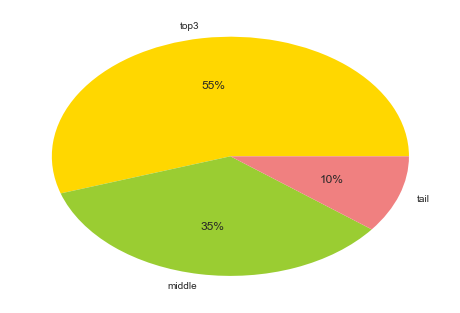

In [6]:
top_order = range(1, 4)
middle_order = range(4, 7)
tail = range(7, 12)

total_runs_scored = df_batting.r.sum()
runs_scored_by_top_order = df_batting[df_batting.position.isin(top_order)].r.sum()
runs_scored_middle_order = df_batting[df_batting.position.isin(middle_order)].r.sum()
runs_scored_tail = df_batting[df_batting.position.isin(tail)].r.sum()

print("Total runs scored: {}".format(total_runs_scored))

# sns.set_style('darkgrid')
plot = plt.pie([runs_scored_by_top_order, runs_scored_middle_order, runs_scored_tail], 
               colors=('gold', 'yellowgreen', 'lightcoral'),
               labels=['top3', 'middle', 'tail'], 
               autopct='%1.0f%%')

It is nearly an even split between top and middle order. Lets dive deeper...

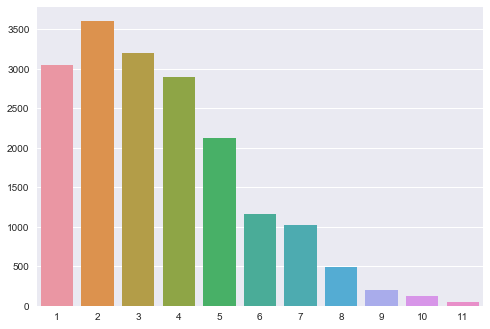

In [7]:
positions = df_batting.position.unique()
runs = [df_batting[df_batting.position == pos].r.sum() for pos in positions]

plot = sns.barplot(x=positions, y=runs)

Had you picked the main opener and 2-down you would be well off in scoring the batting points!

## Bowling Stats

In [8]:
df_bowling = pd.DataFrame(stats['bowling_stats'])
df_bowling.head()

,d,e,maid,match_id,nb,ov,playerId,position,r,w,wd
0,11,7.75,0,5839,0,4,3319,1,31,1,1
1,5,13.75,0,5839,1,4,1111,2,55,1,3
2,5,5.50,0,5839,0,4,111,3,22,1,0
3,2,12.00,0,5839,0,3,162,4,36,0,0
4,3,13.66,0,5839,0,3,227,5,41,0,0


In [9]:
total_wickets = df_bowling.w.sum()
print("Total Wickets taken: {}".format(total_wickets))

Total Wickets taken: 650


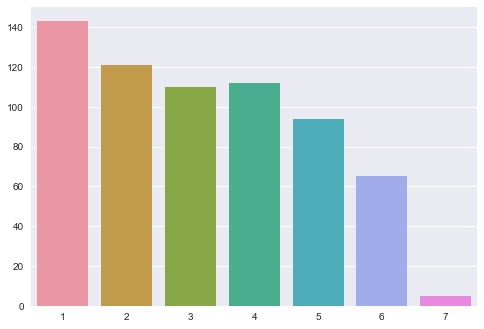

In [9]:
positions = df_bowling.position.unique()
wickets = [df_bowling[df_bowling.position == pos].w.sum() for pos in positions]

plot = sns.barplot(x=positions, y=wickets)

Again you are better off if you pick the top bowler!

In [20]:
all_rounders_ids = set(df_batting.playerId) & set(df_bowling.playerId)
total_players_ids = set(df_batting.playerId) | set(df_bowling.playerId)

print("Total Players: {}".format(len(total_players_ids)))
print("Total Allrounders: {}".format(len(all_rounders_ids)))

Total Players: 160
Total Allrounders: 91


In [23]:
batting_by_allrounders = df_batting[df_batting.playerId.isin(all_rounders)]
print("Total runs by Allrounders: {}".format(batting_by_allrounders.r.sum()))
print("Average run scored by each all rounder: {}".format(batting_by_allrounders.r.sum()/len(all_rounders_ids)))

Total runs by Allrounders: 5983
Average run scored by each all rounder: 65.74725274725274
